### Import all the relevant librbaries

In [1]:
import geopandas as gp, pandas as pd
import matplotlib
import descartes
import matplotlib.pyplot as plt
import numpy as np
import csv
from shapely.geometry import Point
import pyproj
import matplotlib.patheffects as PathEffects

### Set parameters for naming convention

In [2]:
k_n = 6
seed_number = 600
region = "England" 
method = "tSNE"
section = "global"  

In [3]:
#read the dbf file
shp = gp.read_file('./lsoa_boundary/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.dbf')

In [4]:
shp = shp.rename(columns={'lsoa11cd': 'CODE'})

#read clustered data for a region specified in the R code
if method == "PCA":
    df = pd.read_csv("./input_csv's/PCA_diana_6_clust_df_England.csv")
else:
    df = pd.read_csv("./input_csv's/England_original_clustering_tSNE600_nclust_6.csv")

    
#merge the shape file data with the clustered data, based on the LSOA_CODE
geo = shp.merge(df, on='CODE')

geo["CLUSTER"] = ["Cluster "+str(c) for c in geo["CLUSTER"]]

### Replaces clusters, to change the colours on the map (not necessary)

In [102]:
if method == "PCA":
    cl4_list = geo.CLUSTER[geo.CLUSTER == "Cluster 6"].index.tolist()
    cl1_list = geo.CLUSTER[geo.CLUSTER == "Cluster 4"].index.tolist()

    for x in cl4_list:
        geo.at[x, 'CLUSTER'] = "Cluster 4"
    for x in cl1_list:
        geo.at[x, 'CLUSTER'] = "Cluster 6"
else:
    cl4_list = geo.CLUSTER[geo.CLUSTER == "Cluster 6"].index.tolist()
    cl1_list = geo.CLUSTER[geo.CLUSTER == "Cluster 1"].index.tolist()

    for x in cl4_list:
        geo.at[x, 'CLUSTER'] = "Cluster 1"
    for x in cl1_list:
        geo.at[x, 'CLUSTER'] = "Cluster 6"
    
    cl4_list = geo.CLUSTER[geo.CLUSTER == "Cluster 2"].index.tolist()
    cl1_list = geo.CLUSTER[geo.CLUSTER == "Cluster 3"].index.tolist()

    for x in cl4_list:
        geo.at[x, 'CLUSTER'] = "Cluster 3"
    for x in cl1_list:
        geo.at[x, 'CLUSTER'] = "Cluster 2"
        
    cl4_list = geo.CLUSTER[geo.CLUSTER == "Cluster 5"].index.tolist()
    cl1_list = geo.CLUSTER[geo.CLUSTER == "Cluster 3"].index.tolist()

    for x in cl4_list:
        geo.at[x, 'CLUSTER'] = "Cluster 3"
    for x in cl1_list:
        geo.at[x, 'CLUSTER'] = "Cluster 5"


### Convert Lat and Long coordinates of cities to shapefile coordinate system

In [5]:
city_coord = pd.read_csv("./input_csv's/UK_Main_Cities_Lat_Long.csv") #read the CSV with lat and long coordinates of Cities
city_coord = city_coord [0:43]                          #select the number of cities you have

# COMMENT THIS OUT IF NO MASK NEEDED
if region != "England":
    mask = city_coord['Region Name'] == region #create a mask depending on the region
    city_coord = city_coord[mask]              #apply the mask

#convert long and lat coordinates to floats
city_coord.Longitude = city_coord.Longitude.astype(float).fillna(0.0)
city_coord.Latitude = city_coord.Latitude.astype(float).fillna(0.0)

#pyproj coordinate transformation system defined
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum

#create two lists with lat and long coordinates
long = list(city_coord['Longitude'])
lat = list(city_coord['Latitude'])

#create an empty dataframe just for point coordinates
point_coord = pd.DataFrame()

#for loop converting the city long and lat coordinates to shapefile type X,Y coordinates
for i in range(0,len(long)):
    point_coord[i] = pyproj.transform(wgs84, osgb36, long[i], lat[i])

#transposing the dataframe with converted coordinate points
point_coord = point_coord.T  

#concatenate coordinate points into one cell and POINT format
point_coord['Coordinates'] = list(zip(point_coord[0], point_coord[1]))
point_coord = point_coord['Coordinates'].apply(Point)

#create a column with transformted coordinates in the city_coord dataframe
city_coord = city_coord.assign(Coordinates = list(point_coord))

#convert the dataframe into a GeoData dataframe
city_coord = gp.GeoDataFrame(city_coord, geometry="Coordinates")

#city_coord.head()

### Plotting Function

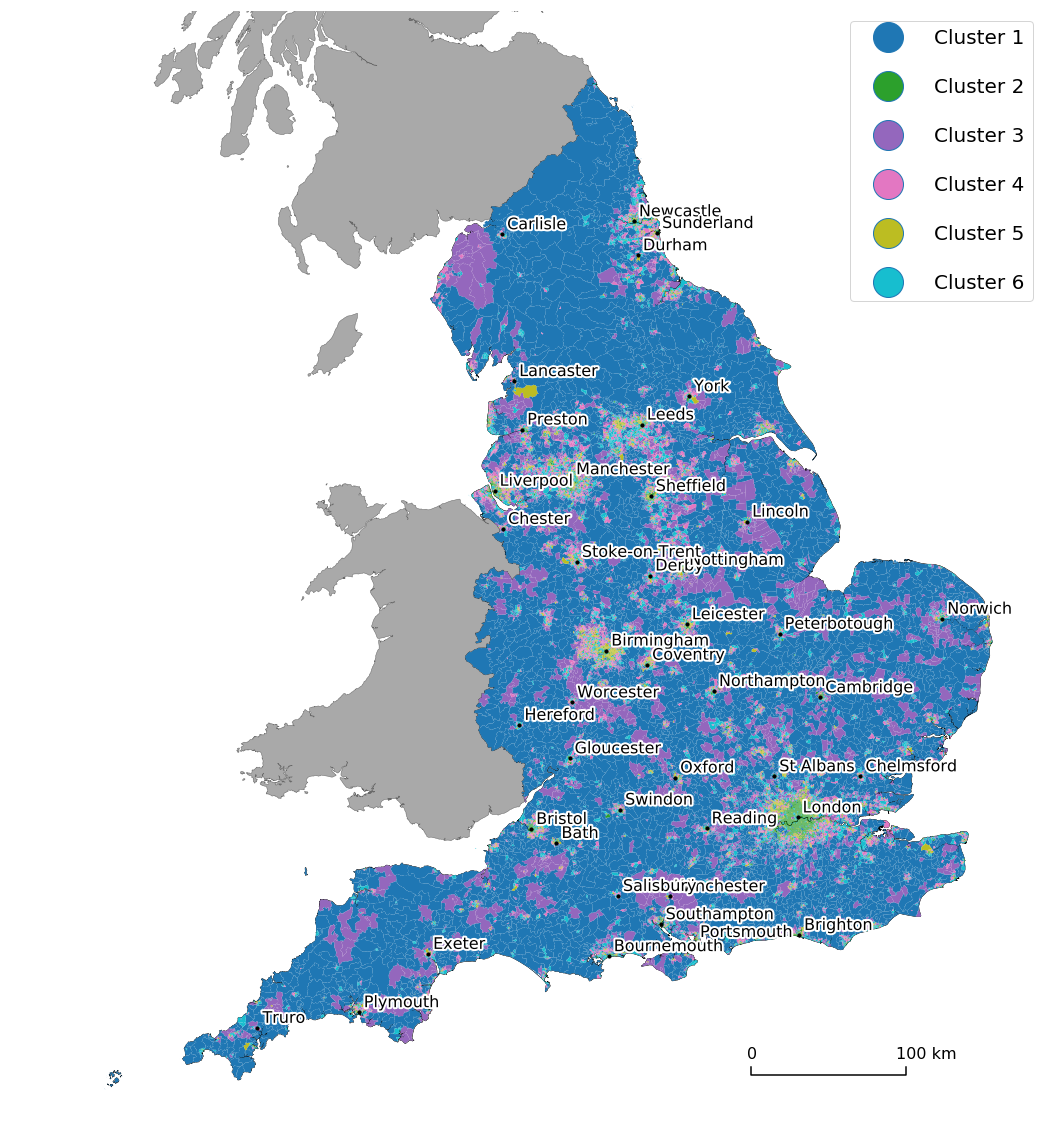

In [7]:
# CONFIGURE PLOTTING PARAMETERS
legend_font_size = 20

point_size = 40
text_size = 16

markers_size = 3


# CONFIGURE FIGURE SETTINGS
params = {'legend.fontsize': legend_font_size,'axes.titlesize':'x-large',
          'legend.markerscale': markers_size, 'legend.labelspacing':1.5,
          'legend.handlelength':3}

plt.rcParams.update(params)
fig,ax1 = plt.subplots(1, figsize=(20, 20))
ax1.set_axis_off()
#plt.axis('equal')


#read the dbf files for GB and England
shp_gb = gp.read_file('./gb_boundary/greatbritain.dbf')
shp_en = gp.read_file('./england_boundary/england.dbf')
#plot the shapefiles for GB and England for outline
shp_gb.plot(ax=ax1, color = 'darkgray', edgecolor='dimgray', linewidth=0.5, alpha=1)
shp_en.plot(ax=ax1, color = 'w', edgecolor='k', linewidth=0.5, alpha=1)

plt.ylim(0,700000)
plt.xlim(50000,)
dx1, dx2 = 500000, 600000

#plot the maps according to clustering dataframe
geo.plot(ax=ax1, column="CLUSTER", legend=True, cmap="tab10", linewidth=1, alpha=1)

#plot city coordinates as points
city_coord.plot(ax=ax1, marker = '.', color='black', markersize = point_size)


#plot the labels for cities
for x, y, label in zip(city_coord.geometry.x, city_coord.geometry.y, city_coord.Name):
    ax1.annotate(label, size = text_size, xy=(x, y), xytext=(5, 5), textcoords="offset points", \
                 path_effects=[PathEffects.withStroke(linewidth=4, foreground="w")])


d_x=[dx1 ,dx1, dx2, dx2]
d_y=[20000, 15000, 15000, 20000]
ax1.plot(d_x,d_y, '-', color = 'k')
ax1.annotate('0', size = text_size, xy = (d_x[0],d_y[0]), xytext=(-4, 8),textcoords="offset points")
ax1.annotate('100 km', size = text_size, xy = (d_x[3],d_y[3]), xytext=(-10, 8),textcoords="offset points")
plt.savefig('./Maps Outputs/{} {} Map_{}_n_{}.pdf'.format(region, section, method, k_n), bbox_inches='tight', transparent=True)
